In [1]:
import pybullet
import time
import pybullet_data
import pybullet_robots
import math
import numpy as np
import threading
import matplotlib.pyplot as plt
import cv2
import os
import csv
%matplotlib inline

In [30]:
#setup constants

#width and height for rgb and depth image
IMG_WIDTH = 160
IMG_HEIGHT = 120

#robot constants
NUM_JOINTS = 7
FINGER_AXES = [9, 10]

#task 
# 1 = push
# 2 = reach
# 3 = cube pick up and drop
task = 3

#data record path
DATA_PATH = "data_all_cams_task_"+str(task)+"_ron"

In [31]:
#setup global variables
runNumber = 0 #folder number to save data

In [32]:
usingVR = True

#setup the simulation
if usingVR:
    physics = pybullet.connect(pybullet.SHARED_MEMORY)
    if (physics<0):
        print('could not use vr!')
    else:
        print('using vr')
else:
    physics = pybullet.connect(pybullet.GUI)

#add a plane to the simulation
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
print(pybullet_data.getDataPath())

using vr
c:\Users\Ronak\anaconda3\envs\torch\lib\site-packages\pybullet_data


In [33]:
# Task 1
def setupPushTask():
    # clear all the objects in the simulation
    pybullet.resetSimulation()
    plainId = pybullet.loadURDF("plane.urdf", [0, 0, 0], useFixedBase=True)

    # #add a table in front of the robot arm
    tableId = pybullet.loadURDF("table/table.urdf", basePosition=[0,0,0])

    #add misc objects to the simulation on the table
    pybullet.loadURDF("lego/lego.urdf", basePosition=[-0.37,0.1,0.7], globalScaling=2)

    # pybullet.loadURDF("tray/traybox.urdf", basePosition=[0.1, -0.3, 0.65], globalScaling=0.5)

    # Define the start and end region positions
    start_region = [-0.37, -0.3, 0.63]
    start_width = 0.15
    start_color = [1,0,0]
    start_lineWidth = 500


    # end_region = [-0.35, 0.2, 0.63]
    # end_width = 0.1
    # end_color = [0,0,1]
    # end_lineWidth = 500

    # Create rectangular regions to highlight the start and end regions
    start_region_lines = [
        pybullet.addUserDebugLine([start_region[0] - start_width, start_region[1] - start_width, start_region[2]],
                                 [start_region[0] + start_width, start_region[1] - start_width, start_region[2]],
                                 lineColorRGB=start_color, lineWidth=start_lineWidth),
        pybullet.addUserDebugLine([start_region[0] + start_width, start_region[1] - start_width, start_region[2]],
                                 [start_region[0] + start_width, start_region[1] + start_width, start_region[2]],
                                 lineColorRGB=start_color, lineWidth=start_lineWidth),
        pybullet.addUserDebugLine([start_region[0] + start_width, start_region[1] + start_width, start_region[2]],
                                 [start_region[0] - start_width, start_region[1] + start_width, start_region[2]],
                                 lineColorRGB=start_color, lineWidth=start_lineWidth),
        pybullet.addUserDebugLine([start_region[0] - start_width, start_region[1] + start_width, start_region[2]],
                                 [start_region[0] - start_width, start_region[1] - start_width, start_region[2]],
                                 lineColorRGB=start_color, lineWidth=start_lineWidth)
    ]

    # end_region_lines = [
    # pybullet.addUserDebugLine([end_region[0] - end_width, end_region[1] - end_width, end_region[2]],
    #                          [end_region[0] + end_width, end_region[1] - end_width, end_region[2]],
    #                          lineColorRGB=end_color, lineWidth=end_lineWidth),
    # pybullet.addUserDebugLine([end_region[0] + end_width, end_region[1] - end_width, end_region[2]],
    #                          [end_region[0] + end_width, end_region[1] + end_width, end_region[2]],
    #                          lineColorRGB=end_color, lineWidth=end_lineWidth),
    # pybullet.addUserDebugLine([end_region[0] + end_width, end_region[1] + end_width, end_region[2]],
    #                          [end_region[0] - end_width, end_region[1] + end_width, end_region[2]],
    #                          lineColorRGB=end_color, lineWidth=end_lineWidth),
    # pybullet.addUserDebugLine([end_region[0] - end_width, end_region[1] + end_width, end_region[2]],
    #                          [end_region[0] - end_width, end_region[1] - end_width, end_region[2]],
    #                          lineColorRGB=end_color, lineWidth=end_lineWidth)
# ]


    #add a robot arm to the simulation
    robotId = pybullet.loadURDF("franka_panda/panda.urdf", [-0,0.3,0.6], useFixedBase=True)
    #set the arm to an experimentally good starting position
    initState = [1.412535051938124, 1.6189544050236317, 0.9125956760870967, -2.606972451796825, -0.648868805466964, 2.6805359081158495, 5.485746666193374]

    for i in range(len(initState)):
        pybullet.resetJointState(robotId, i, initState[i])

    #set the gravity
    pybullet.setGravity(0, 0, -10)

    # create a thread to run the simulation
    pybullet.setRealTimeSimulation(1)
    
    return robotId

# Task 2
def setupReachTask():
    # clear all the objects in the simulation
    pybullet.resetSimulation()
    plainId = pybullet.loadURDF("plane.urdf", [0, 0, 0], useFixedBase=True)

    # #add a table in front of the robot arm
    tableId = pybullet.loadURDF("table/table.urdf", basePosition=[0,0,0])

    #add misc objects to the simulation on the table
    pybullet.loadURDF("lego/lego.urdf", basePosition=[-0.6,-0.2,0.7], globalScaling=2)

    #add a robot arm to the simulation
    robotId = pybullet.loadURDF("franka_panda/panda.urdf", [-0,0.3,0.6], useFixedBase=True)
    # robotId = pybullet.loadURDF("kuka_iiwa/model.urdf", [-0,0.3,0.6], useFixedBase=True)
    #set the arm to an experimentally good starting position
    initState = [1.976510182790837, -1.4559139655311553, 1.2882844021675286, -1.572705259702399, 1.3237965931867992, 1.110313401859266, 2.873038394359566]

    for i in range(len(initState)):
        pybullet.resetJointState(robotId, i, initState[i])

    #set the gravity
    pybullet.setGravity(0, 0, -10)

    # create a thread to run the simulation
    pybullet.setRealTimeSimulation(1)
    
    return robotId

# Task 3
def setupCubeTask():
    # clear all the objects in the simulation
    pybullet.resetSimulation()
    plainId = pybullet.loadURDF("plane.urdf", [0, 0, 0], useFixedBase=True)

    # #add a table in front of the robot arm
    tableId = pybullet.loadURDF("table/table.urdf", basePosition=[0,0,0])

    #add misc objects to the simulation on the table
    pybullet.loadURDF("lego/lego.urdf", basePosition=[-0.6,-0.2,0.7], globalScaling=2)

    pybullet.loadURDF("tray/traybox.urdf", basePosition=[0.1, -0.3, 0.65], globalScaling=0.5)

    #add a robot arm to the simulation
    robotId = pybullet.loadURDF("franka_panda/panda.urdf", [-0,0.3,0.6], useFixedBase=True)
    # robotId = pybullet.loadURDF("kuka_iiwa/model.urdf", [-0,0.3,0.6], useFixedBase=True)
    #set the arm to an experimentally good starting position
    initState = [1.976510182790837, -1.4559139655311553, 1.2882844021675286, -1.572705259702399, 1.3237965931867992, 1.110313401859266, 2.873038394359566]

    for i in range(len(initState)):
        pybullet.resetJointState(robotId, i, initState[i])

    #set the gravity
    pybullet.setGravity(0, 0, -10)

    # create a thread to run the simulation
    pybullet.setRealTimeSimulation(1)
    
    return robotId


In [34]:
def getRandomPos(x_range = [-0.6, -0.2], y_range = [-0.2, 0]):
        x = np.random.uniform(x_range[0], x_range[1])
        y = np.random.uniform(y_range[0], y_range[1])
        return [x, y, 0.7]

def reset():
     if task == 1:
            return setupPushTask()
     elif task == 2:
            return setupReachTask()
     elif task == 3:
            return setupCubeTask()
     
robotId = reset()

In [35]:
# for i in range(0,7):
#     pos = pybullet.getJointState(robotId, i)[0]
#     # pos, orientation = pybullet.getLinkState(robotId, i, computeForwardKinematics=False)[0:2]
#     print(pos)

In [36]:
#Helper functions for controlling the robot arm
isGrabberOpen = False
def openGrabber():
    global isGrabberOpen
    for i in FINGER_AXES:
        pybullet.setJointMotorControl2(robotId, i, pybullet.POSITION_CONTROL, targetPosition=0.04, force=100)
    isGrabberOpen = True

def closeGrabber():
    global isGrabberOpen
    for i in FINGER_AXES:
        pybullet.setJointMotorControl2(robotId, i, pybullet.POSITION_CONTROL, targetPosition=0, force=100)
    isGrabberOpen = False

def setEndEffectorPos(pos, orientation):
    #first get desired joint positions via inverse kinematics
    jointPoses = pybullet.calculateInverseKinematics(robotId, 8, pos, orientation)
    for i in range(len(jointPoses)):
        if i in FINGER_AXES:
            continue
            
        pybullet.setJointMotorControl2(robotId, i, pybullet.POSITION_CONTROL, targetPosition=jointPoses[i], force=100)

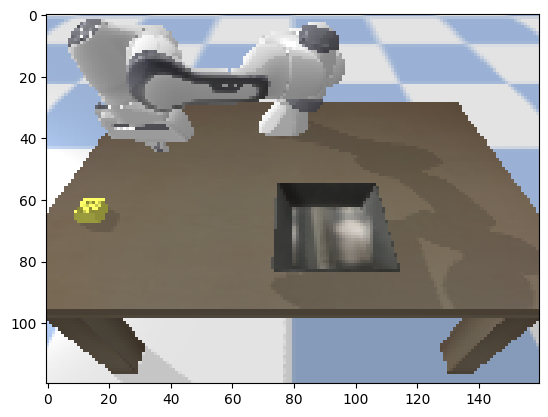

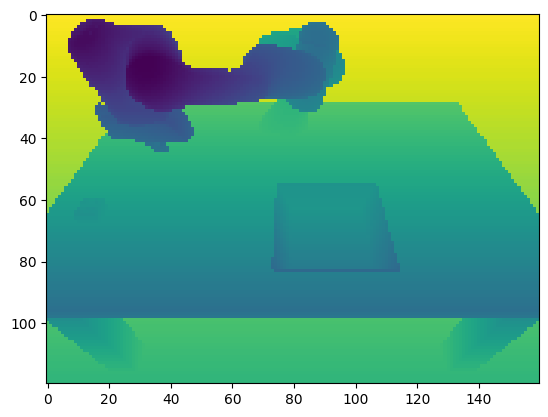

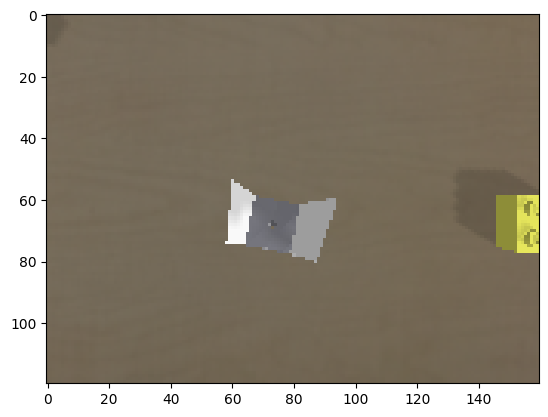

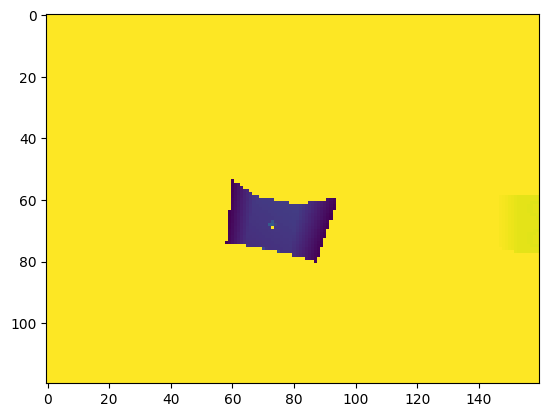

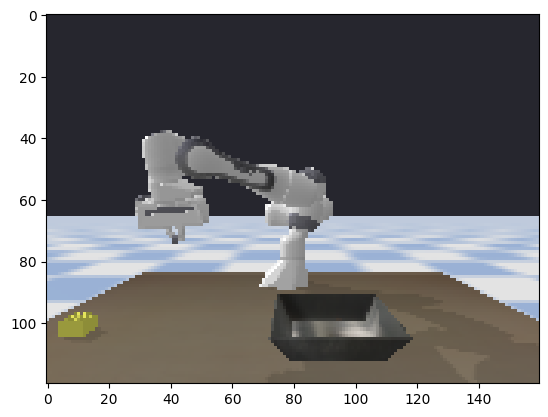

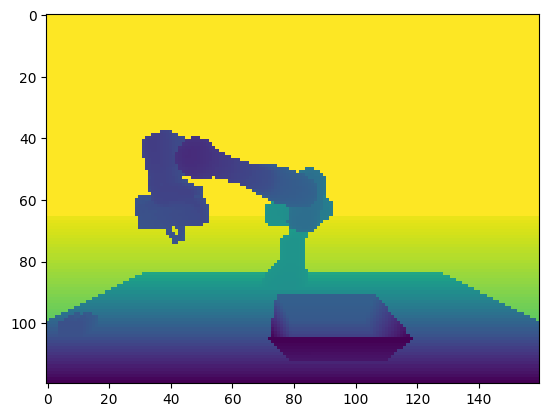

In [37]:
#reset()
def getIsOpen():
    global isGrabberOpen
    return isGrabberOpen

def getPointsOnEndEffector(visualize=False):
    linkNum = 8
    #cet center position
    endEffectorPos, endEffectorOrn = pybullet.getLinkState(robotId, linkNum)[:2]
    #use orientation to compute the other two points
    rotMat = pybullet.getMatrixFromQuaternion(endEffectorOrn)
    rotMat = np.array(rotMat).reshape(3,3)
    localPos = np.array([0, 0.2, 0])
    endEffectorPos2 = endEffectorPos + rotMat.dot(localPos)
    localPos = np.array([0.2, 0, 0])
    endEffectorPos3 = endEffectorPos + rotMat.dot(localPos)

    endState = np.array(endEffectorPos)
    endState = np.append(endState, pybullet.getEulerFromQuaternion(endEffectorOrn))

    if visualize:
        #add small spheres to visualize the points
        pybullet.addUserDebugLine(endEffectorPos, endEffectorPos2, [1,0,0], 1, 0.1)
        pybullet.addUserDebugLine(endEffectorPos, endEffectorPos3, [0,1,0], 1, 0.1)
    
    return [endEffectorPos, endEffectorPos2, endEffectorPos3], endState

def getImagesFromPOV(matrixParameters):
    viewMatrix = pybullet.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=matrixParameters['cameraTargetPosition'], distance=matrixParameters['distance'], yaw=matrixParameters['yaw'], pitch=matrixParameters['pitch'], roll=matrixParameters['roll'], upAxisIndex=matrixParameters['upAxisIndex'])
    projectionMatrix = pybullet.computeProjectionMatrixFOV(fov=60, aspect=float(IMG_WIDTH)/IMG_HEIGHT, nearVal=0.1, farVal=100.0)
    image = pybullet.getCameraImage(IMG_WIDTH, IMG_HEIGHT, viewMatrix=viewMatrix, projectionMatrix=projectionMatrix, shadow=1, lightDirection=[1,1,1], lightColor=[1,1,1], lightDistance=1, lightAmbientCoeff=0.5, lightDiffuseCoeff=0.5, lightSpecularCoeff=0.5, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL, flags=pybullet.ER_NO_SEGMENTATION_MASK)

    #show the image in frame
    width = image[0]
    height = image[1]
    rgb = image[2]
    depth = image[3]
    segmentation = image[4]

    #convert to numpy array
    rgb = np.reshape(rgb, (height, width, 4))
    rgb = rgb[:, :, :3] #remove alpha channel
    
    depth = np.reshape(depth, (height, width))
    return rgb, depth


def getTrainingData():
    '''return everything in a timestep needed for training (rgb img, depth mask, end effector pos, finger open)
    '''

    #get the 3 points on the end effector
    endEffectorPoints, endState = getPointsOnEndEffector()

    #get if the grabber is open
    isOpen = getIsOpen()

    topMatrixParameters = {'cameraTargetPosition':[0,0,0.5],
                           'distance':1.2,
                           'yaw':0,
                           'pitch':-45,
                           'roll':0,
                           'upAxisIndex':2}

    rgb_top, depth_top = getImagesFromPOV(topMatrixParameters)

    newEndEffectorPosition = [endEffectorPoints[0][0]-0.0, endEffectorPoints[0][1]+0.0, endEffectorPoints[0][2]-0]
    effMatrixParameters = {'cameraTargetPosition':newEndEffectorPosition,
                           'distance':-0.06,
                           'yaw':0,
                           'pitch':90,
                           'roll':0,
                           'upAxisIndex':2}

    rgb_eff, depth_eff = getImagesFromPOV(effMatrixParameters)

    sideMatrixParameters = {'cameraTargetPosition':[0,-0.5,1],
                           'distance':0.6,
                           'yaw':0,
                           'pitch':0,
                           'roll':0,
                           'upAxisIndex':2}

    rgb_side, depth_side = getImagesFromPOV(sideMatrixParameters)
    
    return rgb_top, depth_top, rgb_eff, depth_eff,rgb_side, depth_side, endEffectorPoints, endState, isOpen

#visualize sample image
rgb_top, depth_top, rgb_eff, depth_eff,rgb_side, depth_side, endEffectorPoints, endState, isOpen = getTrainingData()
plt.imshow(rgb_top)
plt.show()
plt.imshow(depth_top)
plt.show()
plt.imshow(rgb_eff)
plt.show()
plt.imshow(depth_eff)
plt.show()
plt.imshow(rgb_side)
plt.show()
plt.imshow(depth_side)
plt.show()

In [38]:
isCollectingImgs = False

def saveRGBDepth(rgbImgs, depthImgs, rgbPath, depthPath):
    for i in range(len(rgbImgs)):
        #convert to bgr for opencv
        bgr = rgbImgs[i][:, :, ::-1]
        cv2.imwrite(f"{rgbPath}/rgb{i}.png", bgr)
    
    for i in range(len(depthImgs)):
        #convert to int
        img = (depthImgs[i] * 255).astype(np.uint8)
        cv2.imwrite(f"{depthPath}/depth{i}.png", img)

def continuousRecordImgs10Hz():
    global runNumber
    rgbTopImgs = []
    depthTopImgs = []
    rgbEffImgs = []
    depthEffImgs = []
    rgbSideImgs = []
    depthSideImgs = []
    points = []
    opens = []
    endStates = []
    while isCollectingImgs:
        startTime = time.time()
        rgb_top, depth_top, rgb_eff, depth_eff,rgb_side, depth_side, endEffectorPoints, endState, isOpen = getTrainingData()

        # Saving all images
        rgbTopImgs.append(rgb_top)
        depthTopImgs.append(depth_top)
        rgbEffImgs.append(rgb_eff)
        depthEffImgs.append(depth_eff)
        rgbSideImgs.append(rgb_side)
        depthSideImgs.append(depth_side)
        
        points.append(endEffectorPoints)
        endStates.append(endState)
        opens.append(isOpen)

        endTime = time.time()
        sleepTime = 0.1 - (endTime - startTime)
        if sleepTime > 0:
            time.sleep(sleepTime)
        else:
            print("Warning: Data collection is too slow, took", endTime - startTime, "seconds to collect one image")
    
    #save the images
    dataPath = f"{DATA_PATH}/{runNumber}"
    os.mkdir(dataPath)    
    rgbPathTop = f"{dataPath}/rgb_Top"
    depthPathTop = f"{dataPath}/depth_Top"
    os.mkdir(rgbPathTop)
    os.mkdir(depthPathTop)
    rgbPathEff = f"{dataPath}/rgb_Eff"
    depthPathEff = f"{dataPath}/depth_Eff"
    os.mkdir(rgbPathEff)
    os.mkdir(depthPathEff)
    rgbPathSide = f"{dataPath}/rgb_Side"
    depthPathSide = f"{dataPath}/depth_Side"
    os.mkdir(rgbPathSide)
    os.mkdir(depthPathSide)

    statePath = f"{dataPath}/states"
    os.mkdir(statePath)

    saveRGBDepth(rgbTopImgs, depthTopImgs, rgbPathTop, depthPathTop)
    saveRGBDepth(rgbEffImgs, depthEffImgs, rgbPathEff, depthPathEff)
    saveRGBDepth(rgbSideImgs, depthSideImgs, rgbPathSide, depthPathSide)

    #create a csv file with the points and opens for each time step
    for i in range(len(points)):
        with open(f"{statePath}/states{i}.csv", "w") as f:
            f.write(f'{points[i][0][0]},{points[i][0][1]}')
            f.write(f',{points[i][1][0]},{points[i][1][1]}')
            f.write(f',{points[i][2][0]},{points[i][2][1]}')
            if opens[i]:
                f.write(",1")
            else:
                f.write(",0")
            f.write('\n')
            f.write(f'{endStates[i][0]},{endStates[i][1]},{endStates[i][2]},{endStates[i][3]},{endStates[i][4]},{endStates[i][5]}')      

def stopRun():
    global runNumber
    global isCollectingImgs

    #stop data collection for this run
    isCollectingImgs = False
    time.sleep(0.2) #wait for the thread to stop

def startNextRun():
    global runNumber
    global isCollectingImgs
    #start the next run
    runNumber += 1
    isCollectingImgs = True
    thread = threading.Thread(target=continuousRecordImgs10Hz)
    thread.start()

In [39]:
# # RUSHI CODE

# isRunning = True

# # pybullet.setVRCameraState(trackObject=robotId)
# def updateControllerContinuously():
#     global robotId
    
#     # Button A -> controllerState[6][7]
#     # Button B -> controllerState[6][1]
#     # Front trigger -> controllerState[6][33]
#     # Side trigger -> controllerState[6][34] or controllerState[6][2]

#     # For starting recording use A and Front trigger together
#     # For stopping recording use B and Front trigger together

#     is_recording = 0
#     startRecord = False

#     while isRunning:
#         #get the position and orientation of the controller
#         controllerState = pybullet.getVREvents()
        
#         if len(controllerState)!=2:
#             continue
        
#         #For right controller, use 2nd set
#         controllerState = controllerState[1]

#         if controllerState[6][1]!=0 and controllerState[6][33]!=0:
#             stopRun()
#             print('Recording stopped...')
#             time.sleep(5) #stop mid-reset pictures from being recorded
#             # robotId = reset()
#             # time.sleep(5)
#             startRecord = False

#         elif (controllerState[6][7]!=0 and controllerState[6][33]!=0) or startRecord:
#             startRecord = True
#             #if trigger is pressed, close the grabber
#             if controllerState[6][33] == 1:
#                 closeGrabber()
#             else:
#                 openGrabber()

#             pos = controllerState[1]
#             orientation = controllerState[2]

#             #rotate orientation by 90 degrees in the x axis
#             orientation = pybullet.getEulerFromQuaternion(orientation)
#             orientation = list(orientation)
#             orientation[0] += math.pi
#             orientation = pybullet.getQuaternionFromEuler(orientation)
            
#             setEndEffectorPos(pos, orientation)

#             #convert to tuple
#             orientation = list(orientation)
        
#             time.sleep(3)
#             startNextRun()
#             is_recording = 1
#             print('Recording initiated...')
        
        

# #start the controller thread
# thread = threading.Thread(target=updateControllerContinuously)
# thread.start()

In [ ]:
isRunning = True
# pybullet.setVRCameraState(trackObject=robotId)
def updateControllerContinuously():
    global robotId
    
    # Button A -> controllerState[6][7]
    # Button B -> controllerState[6][1]
    # Front trigger -> controllerState[6][33]
    # Side trigger -> controllerState[6][34] or controllerState[6][2]

    # For starting recording use A and Front trigger together
    # For stopping recording use B and Front trigger together

    is_recording = 0

    while isRunning:

        #get the position and orientation of the controller
        controllerState = pybullet.getVREvents()
        
        if len(controllerState)!=2:
            continue
        
        #For right controller, use 2nd set
        controllerState = controllerState[1]
        
        #if trigger is pressed, close the grabber
        if controllerState[6][33] == 1:
            closeGrabber()
        else:
            openGrabber()

        pos = controllerState[1]
        orientation = controllerState[2]

        #rotate orientation by 90 degrees in the x axis
        orientation = pybullet.getEulerFromQuaternion(orientation)
        orientation = list(orientation)
        orientation[0] += math.pi
        orientation = pybullet.getQuaternionFromEuler(orientation)
        
        setEndEffectorPos(pos, orientation)

        #convert to tuple
        orientation = list(orientation)

        if controllerState[6][7]!=0 and controllerState[6][33]!=0:
            time.sleep(2)
            startNextRun()
            is_recording = 1
            print('Recording initiated...')
        
        if controllerState[6][1]!=0 and controllerState[6][33]!=0:
            stopRun()
            print('Recording stopped...')
            time.sleep(2) #stop mid-reset pictures from being recorded
            # robotId = reset()
            # time.sleep(5)

#start the controller thread
thread = threading.Thread(target=updateControllerContinuously)
thread.start()

Recording initiated...
Recording initiated...Warning: Data collection is too slow, took Warning: Data collection is too slow, took0.3000457286834717  0.2868342399597168 seconds to collect one image

seconds to collect one image

 0.2929811477661133 Warning: Data collection is too slow, tookseconds to collect one image 
0.23493218421936035 seconds to collect one image


seconds to collect one image

 seconds to collect one imageWarning: Data collection is too slow, took
 0.1392197608947754 seconds to collect one image
 0.28046560287475586 seconds to collect one imageWarning: Data collection is too slow, took 
0.289442777633667 seconds to collect one image
 seconds to collect one image
seconds to collect one image
0.30393481254577637 seconds to collect one image
 0.44205522537231445 seconds to collect one image
0.4348323345184326 seconds to collect one image
seconds to collect one image
seconds to collect one image
 seconds to collect one imageWarning: Data collection is too slow, took
 

Exception in thread Thread-14:
Traceback (most recent call last):
  File "c:\Users\Ronak\anaconda3\envs\torch\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Ronak\anaconda3\envs\torch\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Ronak\AppData\Local\Temp/ipykernel_2596/2943470274.py", line 50, in continuousRecordImgs10Hz
FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data_all_cams_task_3_ron/2'


  0.32804346084594727seconds to collect one image 
seconds to collect one image
Recording stopped...
Recording stopped...


In [41]:
#kill the thread
isRunning = False
isCollectingImgs = False

reset()

Exception in thread Thread-13:
Traceback (most recent call last):
  File "c:\Users\Ronak\anaconda3\envs\torch\lib\threading.py", line 980, in _bootstrap_inner
    

4

self.run()
  File "c:\Users\Ronak\anaconda3\envs\torch\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Ronak\AppData\Local\Temp/ipykernel_2596/3002403633.py", line 42, in updateControllerContinuously
  File "C:\Users\Ronak\AppData\Local\Temp/ipykernel_2596/3120337108.py", line 22, in setEndEffectorPos
pybullet.error: Joint index out-of-range.


In [ ]:
#close the simulation
pybullet.disconnect()

# pre-trained model.

In [ ]:
# control the robot arm with a deep learning model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [ ]:
from VRNet import VRNet
from VRNet import DataPreprocessor

In [ ]:
#load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VRNet().to(device)
model.load_state_dict(torch.load("model_all_cams_500epoch_0.0005lr.pt", map_location=device))
model.eval()

#setup data preprocesser

# rgb mean:  tensor([0.5231, 0.5100, 0.4927])
# rgb std:  tensor([0.1867, 0.2083, 0.2512])
# depth mean:  tensor([0.8959])
# depth std:  tensor([0.0430])
# states mean:  tensor([ 0.0081, -0.0053,  0.0088,  0.0304,  0.0053,  0.0292,  0.5139],
#        device='cuda:0')
# states std:  tensor([0.0215, 0.0279, 0.0781, 0.3493, 0.0188, 0.1732, 0.4998],
#        device='cuda:0')


preprocessor = DataPreprocessor(rgb_mean=torch.tensor([0.5231, 0.5100, 0.4927]), rgb_std=torch.tensor([0.1867, 0.2083, 0.2512]), depth_mean=torch.tensor([0.8959]), depth_std=torch.tensor([0.0430]), \
                        state_mean=torch.tensor([ 0.0081, -0.0053,  0.0088,  0.0304,  0.0053,  0.0292,  0.5139]), state_std=torch.tensor([0.0215, 0.0279, 0.0781, 0.3493, 0.0188, 0.1732, 0.4998]))

In [ ]:
def getCurrentEndEffectorPose():
    global robotId
    pos, orientation = pybullet.getLinkState(robotId, 8, computeForwardKinematics=False)[0:2]
    z_off = 0.04
    pos = [pos[0], pos[1], pos[2] + z_off]
    return pos, orientation

#in a separate thread, continuously update the robot arm with the model
modelControllingRobot = True
vels = []
def updateRobotNN():
    startTime = time.time()
    rgb_top, depth_top, rgb_eff, depth_eff,rgb_side, depth_side, endEffectorPoints, endState, isOpen = getTrainingData()

    rgb_top = torch.from_numpy(rgb_top).permute(2, 0, 1)
    depth_top = torch.from_numpy(depth_top)
    rgb_top = rgb_top.unsqueeze(0).to(device).float() / 255
    depth_top = depth_top.unsqueeze(0).unsqueeze(0).to(device).float()

    rgb_eff = torch.from_numpy(rgb_eff).permute(2, 0, 1)
    depth_eff = torch.from_numpy(depth_eff)
    rgb_eff = rgb_eff.unsqueeze(0).to(device).float() / 255
    depth_eff = depth_eff.unsqueeze(0).unsqueeze(0).to(device).float()

    rgb_side = torch.from_numpy(rgb_side).permute(2, 0, 1)
    depth_side = torch.from_numpy(depth_side)
    rgb_side = rgb_side.unsqueeze(0).to(device).float() / 255
    depth_side = depth_side.unsqueeze(0).unsqueeze(0).to(device).float()

    #show images with matplotlib
    # plt.imshow(rgb[0].permute(1, 2, 0).detach().cpu().numpy())
    # plt.show()
    # plt.imshow(depth[0].detach().cpu().numpy())
    # plt.show()

    rgb_top_norm = preprocessor.normalizeRgb(rgb_top.cpu()).to(device)
    depth_top_norm = preprocessor.normalizeDepth(depth_top.cpu()).to(device)

    rgb_eff_norm = preprocessor.normalizeRgb(rgb_eff.cpu()).to(device)
    depth_eff_norm = preprocessor.normalizeDepth(depth_eff.cpu()).to(device)

    rgb_side_norm = preprocessor.normalizeRgb(rgb_side.cpu()).to(device)
    depth_side_norm = preprocessor.normalizeDepth(depth_side.cpu()).to(device)
    
    
    y = model(rgb_top_norm, depth_top_norm, rgb_eff_norm, depth_eff_norm, rgb_side_norm, depth_side_norm)

    #convert the output to a list of velocities
    outputs = y.detach().cpu()
    outputs = preprocessor.denormalizeState(outputs)
    outputs = outputs[0].numpy()
    
    Vx, Vy, Vz, Wx, Wy, Wz, grabberOpen = outputs

    #compute the next position of the end effector in 100 ms
    pos, orn = getCurrentEndEffectorPose()
    x, y, z = pos
    
    x += Vx * 0.5 #use 0.5 instead of 0.1 to make the robot move faster for demos
    y += Vy * 0.5
    z += Vz * 0.5
    # roll += Wx * 0.01 #for simplicity, no angular control
    # pitch += Wy * 0.01
    # yaw += Wz * 0.01
    # vels.append([Vx, Vy, Vz, rgb[0].permute(1, 2, 0).detach().cpu().numpy()])

    pos = np.array([x, y, z])
    orn = pybullet.getQuaternionFromEuler([0, math.pi, -math.pi/1.7])

    #move the robot arm to the next position
    setEndEffectorPos(pos, orn)

    #open or close the grabber
    if grabberOpen > 0.5:
        openGrabber()
    else:
        closeGrabber()
    
    dt = time.time() - startTime
    if dt < 0.1:
        time.sleep(0.1 - dt)
    else:
        print("Warning: updateRobotNN took too long: ", dt)

def updateRobotContinuous():
    while modelControllingRobot:
        updateRobotNN()

#start the thread
thread = threading.Thread(target=updateRobotContinuous)
thread.start()

In [ ]:
modelControllingRobot = False
reset()